## Setup

In [3]:
import getpass
import os


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("OPENAI_API_KEY")

## Define model, tools, and graph state

In [ ]:
from pydantic import BaseModel, Field
from typing import Literal
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState


class WeatherResponse(BaseModel):
    """Respond to the user with this"""

    temperature: float = Field(description="The temperature in fahrenheit")
    wind_directon: str = Field(description="The direction of the wind in abbreviated form")
    wind_speed: float = Field(description="The speed of the wind in km/h")


# Inherit 'messages' key from MessagesState, which is a list of chat messages
class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: WeatherResponse


@tool
def get_weather(city: Literal["paris", "lille", "marseille"]):
    """Use this to get weather information."""
    if city == "paris":
        return "It is cloudy in Paris, with 5 mph winds in the North-East direction and a temperature of 70 degrees"
    elif city == "lille":
        return "It is 65 degrees and raining in Lille, with 3 mph winds in the South-East direction"
    elif city == "marseille":
        return "It is 75 degrees and sunny in Marseille, with 3 mph winds in the South-East direction"
    else:
        raise AssertionError("Unknown city")


tools = [get_weather]

model = ChatOpenAI(model="gpt-4o-mini-2024-07-18", temperature=0, streaming=True)

model_with_tools = model.bind_tools(tools)
model_with_structured_output = model.with_structured_output(WeatherResponse)

## Option 1: Bind output as tool

In [20]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

tools = [get_weather, WeatherResponse]

# Force the model to use tools by passing tool_choice="any"
model_with_response_tool = model.bind_tools(tools, tool_choice="any")


# Define the function that calls the model
def call_model(state: AgentState):
    response = model_with_response_tool.invoke(state["messages"])
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function that responds to the user
def respond(state: AgentState):
    # Construct the final answer from the arguments of the last tool call
    weather_tool_call = state["messages"][-1].tool_calls[0]
    response = WeatherResponse(**weather_tool_call["args"])
    # Since we're using tool calling to return structured output,
    # we need to add  a tool message corresponding to the WeatherResponse tool call,
    # This is due to LLM providers' requirement that AI messages with tool calls
    # need to be followed by a tool message for each tool call
    tool_message = {
        "type": "tool",
        "content": "Here is your structured response",
        "tool_call_id": weather_tool_call["id"],
    }
    # We return the final answer
    return {"final_response": response, "messages": [tool_message]}


# Define the function that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is only one tool call and it is the response tool call we respond to the user
    if (
        len(last_message.tool_calls) == 1
        and last_message.tool_calls[0]["name"] == "WeatherResponse"
    ):
        return "respond"
    # Otherwise we will use the tool node again
    else:
        return "continue"


# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)
graph = workflow.compile()

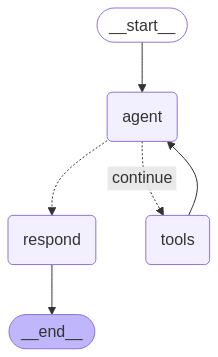

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
answer = graph.invoke(input={"messages": [("human", "what's the weather in Lille?")]})[
    "final_response"
]

answer

WeatherResponse(temperature=65.0, wind_directon='N', wind_speed=15.0)

## Option 2: 2 LLMs

In [ ]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage


# Define the function that calls the model
def call_model(state: AgentState):
    response = model_with_tools.invoke(state["messages"])
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function that responds to the user
def respond(state: AgentState):
    # We call the model with structured output in order to return the same format to the user every time
    # state['messages'][-2] is the last ToolMessage in the convo, which we convert to a HumanMessage for the model to use
    # We could also pass the entire chat history, but this saves tokens since all we care to structure is the output of the tool
    response = model_with_structured_output.invoke(
        [HumanMessage(content=state["messages"][-2].content)]
    )
    # We return the final answer
    return {"final_response": response}


# Define the function that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we respond to the user
    if not last_message.tool_calls:
        return "respond"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)
graph = workflow.compile()

In [17]:
answer = graph.invoke(input={"messages": [("human", "what's the weather in Paris?")]})[
    "final_response"
]
answer

WeatherResponse(temperature=70.0, wind_directon='NE', wind_speed=8.05)